In [40]:
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from tensorflow import keras
from nltk.stem.snowball import RomanianStemmer
from unidecode import unidecode
import sklearn.metrics as metrics

In [9]:
SENT_SIZE = 100
CHAR_FEAT_SIZE = 10
UNKNOWN_WORD = '<UNKNOWN_WORD>'
PADDING_WORD = '<PADDING_WORD>'

In [2]:
df = pd.read_csv("../data/ro_news.csv")
df.head()

,source,title,text,url
0,evz.ro,Ministrul spulberă informațiile despre pensii....,Ministrul Muncii Violeta Alexandru a declarat ...,https://evz.ro/bomba-despre-pensii-ministrul-s...
1,adevarul.ro,G4Media: Klaus Iohannis i-a cerut premierului ...,"Preşedintele Klaus Iohannis i-a cerut, vineri,...",https://adevarul.ro/news/politica/g4media-klau...
2,puterea.ro,ULTIMA ORĂ: Medicul Mircea Beuran a fost REȚIN...,Medicul Mircea Beuran a fost reținut pentru 24...,https://www.puterea.ro/eveniment/ultima-ora-me...
3,agerpres.ro,"Iohannis, în Israel: România - angajată să con...","\r\nTrimisul special al AGERPRES, Florentina P...",https://www.agerpres.ro/politica/2020/01/21/io...
4,news.ro,Avertizări cod galben şi cod portocaliu de plo...,Meteorologii au emis saâmbătă seară avertizări...,https://www.news.ro/social/avertizari-cod-galb...


In [3]:
df['y'] = df['source'].apply(lambda x: x in ('puterea.ro', 'b1.ro')).astype(int)

In [4]:
def clean(txt):
    tokens = word_tokenize(txt)
    stemmer = RomanianStemmer()
    # remove all tokens that are not alpha
    words = [stemmer.stem(unidecode(word.lower())) for word in tokens if word.isalpha()]
    return words

In [5]:
%%time
df['title_clean'] = df['title'].apply(clean)
df['text_clean'] = df['text'].apply(clean)

Wall time: 4min 10s


In [20]:
#WORD FEAT MODEL HELPERS
def get_word2idx(X):
    words = set()
    word2idx = {}
    
    words.add(UNKNOWN_WORD)
    words.add(PADDING_WORD)

    for sent in X:
        for word in sent:
            words.add(word)
    words = sorted(list(words))

    word2idx = { w : i for i, w in enumerate(words) }
    return word2idx

def sentence2idxs(sentence, word2idx):
    sentence_idxs = list(map(lambda w: word2idx.get(w, word2idx[UNKNOWN_WORD]), sentence))
    return sentence_idxs

def convert_data(X, word2idx, sent_size=SENT_SIZE):
    X = list(map(lambda s: sentence2idxs(s, word2idx), X))
    X = keras.preprocessing.sequence.pad_sequences(maxlen=sent_size, sequences=X,
     padding="post", value=word2idx[PADDING_WORD])

    return X


In [16]:
%%time
title_word2idx = get_word2idx(df['title_clean'])
text_word2idx = get_word2idx(df['text_clean'])

Wall time: 538 ms


In [42]:
X_title_w = convert_data(df['title_clean'], title_word2idx)
X_text_w = convert_data(df['text_clean'], text_word2idx)

In [43]:
def word_feat_model(title_word2idx, text_word2idx, sent_size=SENT_SIZE, emb_out_dim=50, n_lstm_units=100):
    # TITLE INPUT
    title_input = keras.layers.Input(shape=(sent_size,))
    title_char_emb = keras.layers.Embedding(input_dim=len(title_word2idx),
        output_dim=emb_out_dim)(title_input)  
    
    # TEXT INPUT
    text_input = keras.layers.Input(shape=(sent_size,))
    text_char_emb = keras.layers.Embedding(input_dim=len(text_word2idx),
        output_dim=emb_out_dim)(title_input)

    all_feat = keras.layers.concatenate([title_char_emb, text_char_emb])

    bi_lstm = keras.layers.Bidirectional(keras.layers.LSTM(units=n_lstm_units,
            return_sequences=False))(all_feat)

    out = keras.layers.Dense(1, activation="sigmoid")(bi_lstm)

    model = keras.models.Model([title_input], out)
    model.compile(optimizer='adam', loss=keras.losses.binary_crossentropy, metrics=['acc'])

    return model

In [38]:
y = df['y'].values

In [44]:
word_model = word_feat_model(title_word2idx, text_word2idx)
word_model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding_13 (Embedding)        (None, 100, 50)      724600      input_14[0][0]                   
__________________________________________________________________________________________________
embedding_14 (Embedding)        (None, 100, 50)      3204750     input_14[0][0]                   
__________________________________________________________________________________________________
concatenate_4 (Concatenate)     (None, 100, 100)     0           embedding_13[0][0]               
                                                                 embedding_14[0][0]         

In [45]:
word_model.fit(x=[X_title_w, X_text_w], y=y, batch_size=32, epochs=3, validation_split=.2)

Train on 15700 samples, validate on 3926 samples
Epoch 1/3
15700/15700 [==============================] - 55s 3ms/sample - loss: 0.3747 - acc: 0.8618 - val_loss: 0.3605 - val_acc: 0.8627
Epoch 2/3
15700/15700 [==============================] - 52s 3ms/sample - loss: 0.2587 - acc: 0.8957 - val_loss: 0.3806 - val_acc: 0.8543
Epoch 3/3
15700/15700 [==============================] - 54s 3ms/sample - loss: 0.1661 - acc: 0.9358 - val_loss: 0.4724 - val_acc: 0.8192


In [46]:
y_hat = word_model.predict([X_title_w, X_text_w])
y_hat = np.round(y_hat)

In [47]:
metrics.classification_report(y, y_hat, output_dict=True)

{'0': {'precision': 0.9657071783937455,
  'recall': 0.9670244943953502,
  'f1-score': 0.9663653874648096,
  'support': 16861},
 '1': {'precision': 0.7972283005105762,
  'recall': 0.7905967450271247,
  'f1-score': 0.7938986744143818,
  'support': 2765},
 'accuracy': 0.9421685519209212,
 'macro avg': {'precision': 0.8814677394521608,
  'recall': 0.8788106197112375,
  'f1-score': 0.8801320309395957,
  'support': 19626},
 'weighted avg': {'precision': 0.941971109029282,
  'recall': 0.9421685519209212,
  'f1-score': 0.9420674937735617,
  'support': 19626}}

In [67]:
import itertools

def grid_search(df):
    title_word2idx = get_word2idx(df['title_clean'])
    text_word2idx = get_word2idx(df['text_clean'])
    
    y = df['y']
    
    best_config = None
    
    
    grid = {
        'sent_sizes' : [50, 75, 100],
        'emb_out_dim' : [50, 100],
        'n_lstm_units' : [100, 150],
        'batch_s' : [32, 64],
        
    }
    
    lists_keys = ['sent_sizes', 'emb_out_dim', 'n_lstm_units', 'batch_s']
    lists_vals = list(map(lambda k: grid[k], lists_keys))
    
    prod = list(itertools.product(*lists_vals))
    
    for (s_size, emb_dim, n_lstm, b_s) in itertools.product(*lists_vals):
        X_title_w = convert_data(df['title_clean'], title_word2idx, sent_size=s_size)
        X_text_w = convert_data(df['text_clean'], text_word2idx, sent_size=s_size)
        
        model = word_feat_model(title_word2idx, text_word2idx, sent_size=s_size, emb_out_dim=emb_dim, n_lstm_units=n_lstm)
        
        es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)
        model.fit(x=[X_title_w, X_text_w], y=y, batch_size=b_s, epochs=10, validation_split=.2, callbacks=[es])
        
        y_hat = model.predict([X_title_w, X_text_w])
        y_hat = np.round(y)
        
        metrics_ = metrics.classification_report(y, y_hat, output_dict=True)
        f1_ = metrics_['1']['f1-score']
        if best_config is None or best_config['f1'] < f1_:
            best_config = {
                'sent_sizes' : s_size,
                'emb_out_dim' : emb_dim,
                'n_lstm_units' : n_lstm,
                'batch_s' : b_s,
                'f1' : f1_,
                'metrics' : metrics_
            }
    
    return best_config
    

In [69]:
title_word2idx = get_word2idx(df['title_clean'])
text_word2idx = get_word2idx(df['text_clean'])

y = df['y']

(s_size, emb_dim, n_lstm, b_s) = (50, 50, 100, 32)
X_title_w = convert_data(df['title_clean'], title_word2idx, sent_size=s_size)
X_text_w = convert_data(df['text_clean'], text_word2idx, sent_size=s_size)

model = word_feat_model(title_word2idx, text_word2idx, sent_size=s_size, emb_out_dim=emb_dim, n_lstm_units=n_lstm)

es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)
model.fit(x=[X_title_w, X_text_w], y=y, batch_size=b_s, epochs=10, validation_split=.2, callbacks=[es])

y_hat = model.predict([X_title_w, X_text_w])
y_hat = np.round(y_hat)

metrics_ = metrics.classification_report(y, y_hat, output_dict=True)


print(model.summary())

Train on 15700 samples, validate on 3926 samples
Epoch 1/10
15700/15700 [==============================] - 42s 3ms/sample - loss: 0.3755 - acc: 0.8631 - val_loss: 0.3687 - val_acc: 0.8594
Epoch 2/10
15700/15700 [==============================] - 36s 2ms/sample - loss: 0.2580 - acc: 0.8964 - val_loss: 0.3811 - val_acc: 0.8569
Epoch 3/10
15700/15700 [==============================] - 37s 2ms/sample - loss: 0.1694 - acc: 0.9337 - val_loss: 0.4486 - val_acc: 0.8385


NameError: name 'f1_' is not defined

In [71]:
model.summary()

Model: "model_34"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_70 (InputLayer)           [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding_69 (Embedding)        (None, 50, 50)       724600      input_70[0][0]                   
__________________________________________________________________________________________________
embedding_70 (Embedding)        (None, 50, 50)       3204750     input_70[0][0]                   
__________________________________________________________________________________________________
concatenate_32 (Concatenate)    (None, 50, 100)      0           embedding_69[0][0]               
                                                                 embedding_70[0][0]        

In [70]:
best_config = {
    'sent_sizes' : s_size,
    'emb_out_dim' : emb_dim,
    'n_lstm_units' : n_lstm,
    'batch_s' : b_s,
    'metrics' : metrics_
}
best_config

{'sent_sizes': 50,
 'emb_out_dim': 50,
 'n_lstm_units': 100,
 'batch_s': 32,
 'metrics': {'0': {'precision': 0.9576753367394334,
   'recall': 0.9782931024257161,
   'f1-score': 0.9678744315681385,
   'support': 16861},
  '1': {'precision': 0.8476269775187344,
   'recall': 0.7363471971066908,
   'f1-score': 0.7880781885039675,
   'support': 2765},
  'accuracy': 0.944206664628554,
  'macro avg': {'precision': 0.9026511571290838,
   'recall': 0.8573201497662035,
   'f1-score': 0.8779763100360529,
   'support': 19626},
  'weighted avg': {'precision': 0.9421712241721638,
   'recall': 0.944206664628554,
   'f1-score': 0.9425439204057807,
   'support': 19626}}}

In [68]:
grid_search(df)

Train on 15700 samples, validate on 3926 samples
Epoch 1/10
15700/15700 [==============================] - 33s 2ms/sample - loss: 0.3760 - acc: 0.8615 - val_loss: 0.3598 - val_acc: 0.8599
Epoch 2/10
15700/15700 [==============================] - 32s 2ms/sample - loss: 0.2568 - acc: 0.8968 - val_loss: 0.3810 - val_acc: 0.8553
Epoch 3/10
15700/15700 [==============================] - 32s 2ms/sample - loss: 0.1679 - acc: 0.9355 - val_loss: 0.4540 - val_acc: 0.8360
Train on 15700 samples, validate on 3926 samples
Epoch 1/10
15700/15700 [==============================] - 27s 2ms/sample - loss: 0.3823 - acc: 0.8591 - val_loss: 0.3664 - val_acc: 0.8571
Epoch 2/10
15700/15700 [==============================] - 22s 1ms/sample - loss: 0.2698 - acc: 0.8887 - val_loss: 0.3809 - val_acc: 0.8561
Epoch 3/10
15700/15700 [==============================] - 22s 1ms/sample - loss: 0.1795 - acc: 0.9288 - val_loss: 0.4468 - val_acc: 0.8444
Train on 15700 samples, validate on 3926 samples
Epoch 1/10
15700/15

{'sent_sizes': 50,
 'emb_out_dim': 50,
 'n_lstm_units': 100,
 'batch_s': 32,
 'f1': 1.0,
 'metrics': {'0': {'precision': 1.0,
   'recall': 1.0,
   'f1-score': 1.0,
   'support': 16861},
  '1': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 2765},
  'accuracy': 1.0,
  'macro avg': {'precision': 1.0,
   'recall': 1.0,
   'f1-score': 1.0,
   'support': 19626},
  'weighted avg': {'precision': 1.0,
   'recall': 1.0,
   'f1-score': 1.0,
   'support': 19626}}}

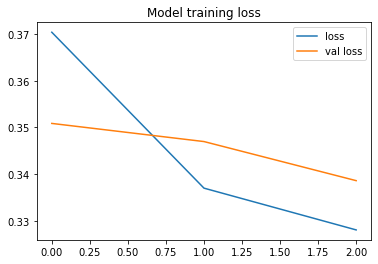

In [43]:
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label='val loss')
plt.title('Model training loss')
plt.legend()

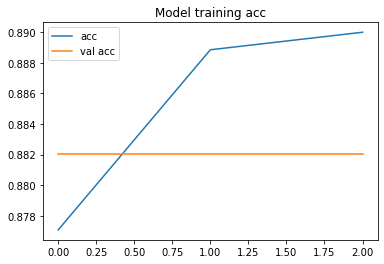

In [44]:
plt.plot(hist.history['acc'], label='acc')
plt.plot(hist.history['val_acc'], label='val acc')
plt.title('Model training acc')
plt.legend()